In [1]:
%matplotlib inline


Neural Networks
===============

Neural networks can be constructed using the ``torch.nn`` package.

Now that you had a glimpse of ``autograd``, ``nn`` depends on
``autograd`` to define models and differentiate them.
An ``nn.Module`` contains layers, and a method ``forward(input)``\ that
returns the ``output``.

A typical training procedure for a neural network is as follows:

- Define the neural network that has some learnable parameters (or
  weights)
- Iterate over a dataset of inputs
- Process input through the network
- Compute the loss (how far is the output from being correct)
- Propagate gradients back into the network’s parameters
- Update the weights of the network, typically using a simple update rule:
  ``weight = weight - learning_rate * gradient``

Define the network
------------------

Let’s define this network:



In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        # 1 input image channel, 6 output channels, 3x3 square convolution
        # kernel
        self.conv1 = nn.Conv2d(1, 6, 3)
        self.conv2 = nn.Conv2d(6, 16, 3)
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(16 * 6 * 6, 120)  # 6*6 from image dimension 
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        # Max pooling over a (2, 2) window
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        # If the size is a square you can only specify a single number
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features


net = Net()
print(net)

Net(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=576, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)


You just have to define the ``forward`` function, and the ``backward``
function (where gradients are computed) is automatically defined for you
using ``autograd``.
You can use any of the Tensor operations in the ``forward`` function.

The learnable parameters of a model are returned by ``net.parameters()``



In [3]:
params = list(net.parameters())
print(len(params))
print(params[0].size())  # conv1's .weight
print(list(net.named_parameters())[1])  # conv1's .bias

10
torch.Size([6, 1, 3, 3])
('conv1.bias', Parameter containing:
tensor([ 0.1535,  0.3264, -0.1878,  0.0813, -0.1803,  0.1966],
       requires_grad=True))


Let's try a random 32x32 input.
Note: expected input size of this net (LeNet) is 32x32. To use this net on
the MNIST dataset, please resize the images from the dataset to 32x32.



In [4]:
input = torch.randn(1, 1, 32, 32)
out = net(input)
print(out)

tensor([[-0.1459, -0.1089, -0.0900,  0.0025,  0.0626, -0.1342,  0.0097, -0.1109,
          0.0078, -0.0194]], grad_fn=<AddmmBackward>)


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


Zero the gradient buffers of all parameters and backprops with random
gradients:



In [5]:
net.zero_grad()
out.backward(torch.randn(1, 10))

<div class="alert alert-info"><h4>Note</h4><p>``torch.nn`` only supports mini-batches. The entire ``torch.nn``
    package only supports inputs that are a mini-batch of samples, and not
    a single sample.

    For example, ``nn.Conv2d`` will take in a 4D Tensor of
    ``nSamples x nChannels x Height x Width``.

    If you have a single sample, just use ``input.unsqueeze(0)`` to add
    a fake batch dimension.</p></div>

Before proceeding further, let's recap all the classes you’ve seen so far.

**Recap:**
  -  ``torch.Tensor`` - A *multi-dimensional array* with support for autograd
     operations like ``backward()``. Also *holds the gradient* w.r.t. the
     tensor.
  -  ``nn.Module`` - Neural network module. *Convenient way of
     encapsulating parameters*, with helpers for moving them to GPU,
     exporting, loading, etc.
  -  ``nn.Parameter`` - A kind of Tensor, that is *automatically
     registered as a parameter when assigned as an attribute to a*
     ``Module``.

**At this point, we covered:**
  -  Defining a neural network
  -  Processing inputs and calling backward

**Still Left:**
  -  Computing the loss
  -  Updating the weights of the network

Loss Function
-------------
A loss function takes the (output, target) pair of inputs, and computes a
value that estimates how far away the output is from the target.

There are several different
loss functions https://pytorch.org/docs/nn.html#loss-functions under the
nn package .
A simple loss is: ``nn.MSELoss`` which computes the mean-squared error
between the input and the target.

For example:



In [6]:
output = net(input)
target = torch.randn(10)  # a dummy target, for example
target = target.view(1, -1)  # make it the same shape as output
criterion = nn.MSELoss()

loss = criterion(output, target)
print(loss)

tensor(0.4609, grad_fn=<MseLossBackward>)


Now, if you follow ``loss`` in the backward direction, using its
``.grad_fn`` attribute, you will see a graph of computations that looks
like this:

::

    input -> conv2d -> relu -> maxpool2d -> conv2d -> relu -> maxpool2d
          -> view -> linear -> relu -> linear -> relu -> linear
          -> MSELoss
          -> loss

So, when we call ``loss.backward()``, the whole graph is differentiated
w.r.t. the loss, and all Tensors in the graph that has ``requires_grad=True``
will have their ``.grad`` Tensor accumulated with the gradient.



Backprop
--------
To backpropagate the error all we have to do is to ``loss.backward()``.
You need to clear the existing gradients though, else gradients will be
accumulated to existing gradients.


Now we shall call ``loss.backward()``, and have a look at conv1's bias
gradients before and after the backward.



In [7]:
net.zero_grad()     # zeroes the gradient buffers of all parameters

print('conv1.bias.grad before backward')
print(net.conv1.bias.grad)

loss.backward()

print('conv1.bias.grad after backward')
print(net.conv1.bias.grad)

conv1.bias.grad before backward
tensor([0., 0., 0., 0., 0., 0.])
conv1.bias.grad after backward
tensor([ 0.0214, -0.0044,  0.0043,  0.0019, -0.0029, -0.0095])


Now, we have seen how to use loss functions.

**Read Later:**

  The neural network package contains various modules and loss functions
  that form the building blocks of deep neural networks. A full list with
  documentation is https://pytorch.org/docs/nn.

**The only thing left to learn is:**

  - Updating the weights of the network

Update the weights
------------------
The simplest update rule used in practice is the Stochastic Gradient
Descent (SGD):

     weight = weight - learning_rate * gradient

We can implement this using simple Python code:

    learning_rate = 0.01
    for f in net.parameters():
        f.data.sub_(f.grad.data * learning_rate)

However, as you use neural networks, you want to use various different
update rules such as SGD, Nesterov-SGD, Adam, RMSProp, etc.
To enable this, we built a small package: ``torch.optim`` that
implements all these methods. Using it is very simple:



In [8]:
import torch.optim as optim

# create your optimizer
optimizer = optim.SGD(net.parameters(), lr=0.01)

# in your training loop:
optimizer.zero_grad()   # zero the gradient buffers
output = net(input)
loss = criterion(output, target)
loss.backward()
optimizer.step()    # Does the update

# Build Your Own Neural Network

### 1. Nonlinear Regression on Sinusoidal Data

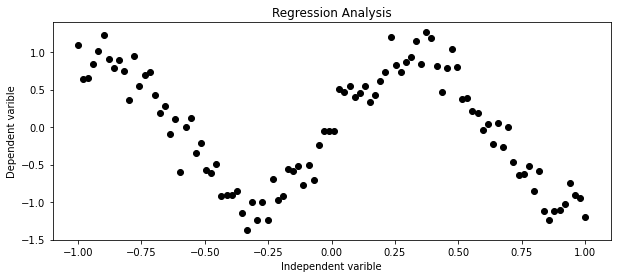

In [9]:
from matplotlib import pyplot as plt
x = torch.unsqueeze(torch.linspace(-1, 1, 100), dim=1)  
y = torch.sin(x * 5) + 0.2 * torch.randn_like(x)

plt.figure(figsize=(10,4))
plt.scatter(x.data.numpy(), y.data.numpy(), color = "black")
plt.title('Regression Analysis')
plt.xlabel('Independent varible')
plt.ylabel('Dependent varible')
plt.show()


In [10]:
# TODO 1: Build your own neural network module that predicts y given (1-dimensional) x
class RegressionNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(1, 10)
        self.fc2 = nn.Linear(10, 10)
        self.fc3 = nn.Linear(10, 1)

    def forward(self, x):
        h = F.relu(self.fc1(x))
        h = F.relu(self.fc2(h))
        return self.fc3(h)

In [11]:
# TODO 2: Train your neural network with SGD to fit the given (x, y) data
net = RegressionNetwork()
optimizer = optim.SGD(net.parameters(), lr=0.1)
loss = nn.MSELoss()

for _ in range(500):
    optimizer.zero_grad()
    loss(net(x), y).backward()
    optimizer.step()

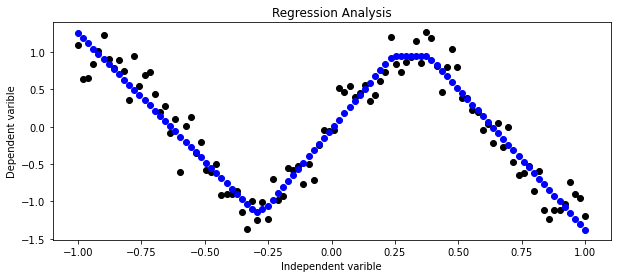

In [12]:
plt.figure(figsize=(10,4))
plt.scatter(x.data.numpy(), y.data.numpy(), color = "black")
plt.scatter(x.data.numpy(), net(x).data.numpy(), color = "blue")
plt.title('Regression Analysis')
plt.xlabel('Independent varible')
plt.ylabel('Dependent varible')
plt.show()

### 2. Nonlinear Classification

In [13]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons
from sklearn.metrics import accuracy_score, precision_score, recall_score
import matplotlib.pyplot as plt
import seaborn as sns
from torch.distributions import constraints

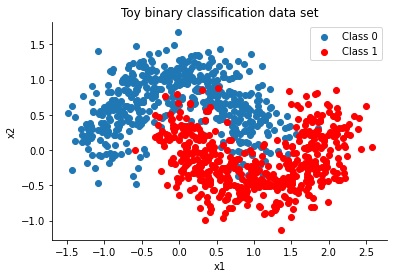

In [14]:
X, Y = make_moons(noise=0.25, random_state=0, n_samples=1000)
fig, ax = plt.subplots()
ax.scatter(X[Y==0, 0], X[Y==0, 1], label='Class 0')
ax.scatter(X[Y==1, 0], X[Y==1, 1], color='r', label='Class 1')
sns.despine(); ax.legend()
ax.set(xlabel='x1', ylabel='x2', title='Toy binary classification data set');

In [15]:
train_x, test_x, train_y, test_y = train_test_split(X, Y, test_size=.5)
train_x = torch.Tensor(train_x).float()
test_x = torch.Tensor(test_x).float()
train_y = torch.Tensor(train_y).long()
test_y = torch.Tensor(test_y).long()

In [16]:
# TODO 3. Build your own neural network that predicts the class y of a given (2-dimensional) x 
class ClassificationNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(2, 20)
        self.fc2 = nn.Linear(20, 20)
        self.fc3 = nn.Linear(20, 20)
        self.fc4 = nn.Linear(20, 2)
        self.softmax = nn.Softmax(dim=1)
        
    def forward(self, x):
        h = F.relu(self.fc1(x))
        h = F.relu(self.fc2(h))
        y = self.softmax(self.fc3(h))
        return y

In [17]:
# TODO 4: Train your neural network with SGD to fit the given (x, y) data
net = ClassificationNetwork() 
optimizer = torch.optim.SGD(net.parameters(), lr=1)
loss = nn.CrossEntropyLoss()

for _ in range(1000):
    optimizer.zero_grad()
    out = net(train_x)
    loss(out, train_y).backward()
    optimizer.step()

Train Accuracy: 0.948
Test Accuracy: 0.93


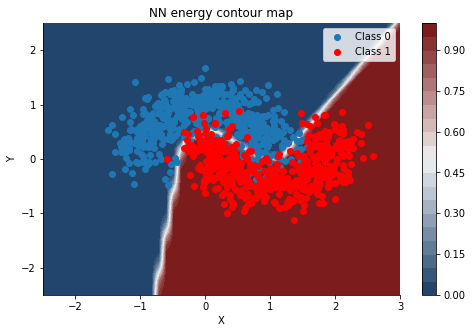

In [18]:
predict_out = net(train_x)
_, predict_y = torch.max(predict_out, 1)
print("Train Accuracy:",accuracy_score(train_y.data, predict_y.data))
predict_out = net(test_x)
_, predict_y = torch.max(predict_out, 1)
print("Test Accuracy:",accuracy_score(test_y.data, predict_y.data))

# Defining the mesh for contour plots
x = np.linspace(-2.5, 3, 50)
y = np.linspace(-2.5, 2.5, 40)
mesh = np.meshgrid(x, y)
a=np.zeros((2000,2))
a[:,0]=np.ravel(mesh[0])
a[:,1]=np.ravel(mesh[1])
contour_test=torch.Tensor(a)

predict_out = net(contour_test)
contour_plot=predict_out.detach().numpy()[:,1]

cmap = sns.diverging_palette(250, 12, s=85, l=25, as_cmap=True)
fig, ax = plt.subplots(figsize=(8, 5))
contour=ax.contourf(mesh[0], mesh[1], contour_plot.reshape(40,50),20, cmap=cmap);
cbar = plt.colorbar(contour)
ax.scatter(X[Y==0, 0], X[Y==0, 1], label='Class 0')
ax.scatter(X[Y==1, 0], X[Y==1, 1], color='r', label='Class 1')
sns.despine(); ax.legend()
ax.set(xlabel='X', ylabel='Y', title='NN energy contour map');